# The task

From taks 3, we are familiar with the model to predict default probability and potential losses. The personal loans and risk team is using the model as a guide to loss provisions for the upcoming year. The team now wants to look at their mortgage book. They suspect that FICO scores will provide a good indication of how likely a customer is to default on their mortgage. The team wants to build a machine learning model that will predict the probability of default. The architecture they are using requires categorical data. As FICO ratings can take integer values in a large range, they will need to be mapped into buckets. They ask if we can find the best way of doing this to analyze the data. The process of doing this is known as quantization. We could consider many ways of solving the problem by optimizing different properties of the resulting buckets, such as the mean squared error (MSE) or log-likelihood. 

The data is provided here (https://cdn.theforage.com/vinternships/companyassets/Sj7temL583QAYpHXD/JiwEkbBq8pFwMRYLc/1684245611456/Task%203%20and%204_Loan_Data.csv).

# The Lloyd-Max algorithm for quantization

The task is essentially a one-dimensional quantization problem. The goal is to find the boundaries of different buckets and the representative value of each bucket. We can use sklearn.cluster.KMeans to solve it. However, KMeans cannot guarantee the centroids, i.e., the representative value of each bucket, are integers; and KMeans doesn't give boundries, but only tells which bucket (cluster) each data point is in. The extra steps are: (1) to approximate those centroids as integers by rounding; and (2) using each cluster's maximum and minimum values to find the boundaries. The other option is to implement the Lloyd-Max algorithm using dynamic programming to solve it. The details of the algorithm can be found here: https://en.wikipedia.org/wiki/Lloyd%27s_algorithm and https://ocw.mit.edu/courses/6-450-principles-of-digital-communications-i-fall-2006/926689aaa62a0315473fa9b982de1b07_book_3.pdf. I will first implement the Lloyd-Max algorithm without limiting the representative values as integers and use KMeans to validate the implementation, and then limit the representative values to integers only to see whether it makes big differences to the MSE.

In [1]:
import pandas as pd
import numpy as np
import bisect
import matplotlib.pyplot as plt

In [2]:
borrowers = pd.read_csv('./Task 3 and 4_Loan_Data.csv')
borrowers.set_index('customer_id', inplace=True)

In [3]:
# implement Lloyd-Max algorithm
def dp_lloyd_quantization(data, n, tol=0.00001, max_iter=500, is_integer=False):
    data = sorted(data)
    l = len(data)
    mse = float('inf')
    centroids = [data[i] for i in range(0, l//n*n, l//n)]
    while max_iter > 0:
        interval = [-float('inf')] + [0.5*(centroids[i]+centroids[i+1]) for i in range(len(centroids)-1)] \
                    + [float('inf')]
        se = 0
        counter = []
        for j in range(len(interval) - 1):
            nums = data[bisect.bisect_right(data, interval[j]):bisect.bisect_right(data, interval[j+1])]
            centroids[j] = np.mean(nums)
            if is_integer:
                centroids[j] = int(round(centroids[j], 0))
            se += np.var(nums) * len(nums)
            counter.append(len(nums))
        if mse - se/l > tol:
            mse = se/l
            max_iter -= 1
        else:
            break
    return centroids, mse, interval, counter

In [4]:
# when the number of buckets is 8 and without limiting the representative values to be integers
centroids, mse, interval, counter = dp_lloyd_quantization(data=borrowers.fico_score.values, n=8, 
                                                          tol=0.00001, max_iter=500)
print(f"The representative values of each bucket are: {centroids}\n")
print(f"The MSE is: {mse}\n")
print(f"The boundaries of buckets are: {interval}\n")
print(f"The number of data points in each bucket are: {counter}")

The representative values of each bucket are: [498.64057971014495, 550.6336206896551, 586.3137931034482, 616.5715915573303, 645.2651708312086, 676.5701086956522, 712.6266129032258, 761.1635610766045]

The MSE is: 125.66896199112011

The boundaries of buckets are: [-inf, 524.6371001999, 568.4737068965517, 601.4426923303893, 630.9183811942694, 660.9176397634303, 694.598360799439, 736.8950869899152, inf]

The number of data points in each bucket are: [345, 928, 1450, 1753, 1961, 1840, 1240, 483]


In [5]:
# when the number of buckets is 8 and the the representative values are limited to integers
centroids, mse, interval, counter = dp_lloyd_quantization(data=borrowers.fico_score.values, n=8, 
                                                          tol=0.00001, max_iter=500, is_integer=True)
print(f"The representative values of each bucket are: {centroids}\n")
print(f"The MSE is: {mse}\n")
print(f"The boundaries of buckets are: {interval}\n")
print(f"The number of data points in each bucket are: {counter}")

The representative values of each bucket are: [499, 552, 587, 618, 647, 678, 714, 763]

The MSE is: 124.99724103265251

The boundaries of buckets are: [-inf, 525.5, 569.5, 602.5, 632.5, 662.5, 696.0, 738.5, inf]

The number of data points in each bucket are: [356, 948, 1469, 1822, 1979, 1769, 1209, 448]


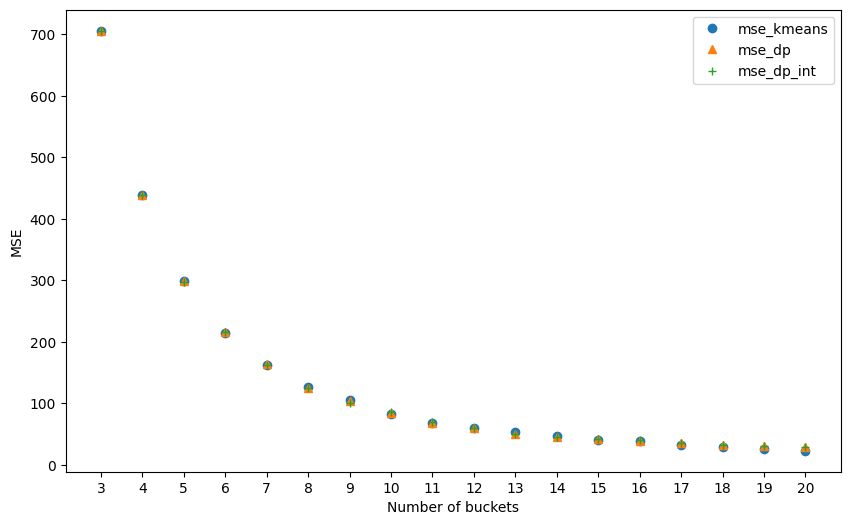

In [7]:
# compare my implementation results with the KMeans results
# it is obvious that the more buckets we have, the smaller the MSE tends to be. So we need to compare the MSE
# at the same number of buckets (or clusters).
from sklearn.cluster import KMeans
fico = borrowers.fico_score.values.reshape(-1, 1)
mse_kmeans = []
mse_dp = []
mse_dp_int = []
for i in range(3, 21):
    kmeans = KMeans(n_clusters=i, n_init='auto', max_iter=500, tol=0.00001, verbose=0, 
                    random_state=100, copy_x=True, algorithm='lloyd')
    kmeans.fit(fico)
    mse_kmeans.append(kmeans.inertia_ / len(fico))
    centroids, mse, interval, counter = dp_lloyd_quantization(data=borrowers.fico_score.values, 
                                                                  n=i, tol=0.00001, max_iter=500)
    mse_dp.append(mse)
    centroids, mse, interval, counter = dp_lloyd_quantization(data=borrowers.fico_score.values, 
                                                                n=i, tol=0.00001, max_iter=500, 
                                                                  is_integer=True)
    mse_dp_int.append(mse)
df = pd.DataFrame({'n_buckets': range(3,21), 'mse_kmeans': mse_kmeans, 'mse_dp': mse_dp, 
                   'mse_dp_int': mse_dp_int})
plt.figure(figsize=(10,6))
plt.plot(df['n_buckets'], df['mse_kmeans'], 'o', label='mse_kmeans')
plt.plot(df['n_buckets'], df['mse_dp'], '^', label='mse_dp')
plt.plot(df['n_buckets'], df['mse_dp_int'], '+', label='mse_dp_int')
plt.xlabel('Number of buckets')
plt.ylabel('MSE')
plt.xticks(df['n_buckets'])
plt.legend()
plt.show()

# Comparison with KMeans

From the comparison above, we can see that my implementation with representative values of each bucket being limited to integers have very close MSE to the KMeans results. We can use the implementation to quantize the FICO scores.